<a href="https://colab.research.google.com/github/valesierrai/Analisis-Supervisado-para-el-AD/blob/main/Reto2_con_Capas_VSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Cargamos Librerias

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Cargamos el archivo de etiquetas
labels_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Aprendizaje Supervisado/Fotos Conjunto/informacion.xlsx', header = None)

In [ ]:
#Visualizamos
labels_df.head()

,0,1
0,20240920_102803,flor
1,20240920_102825,orquidea
2,20240920_102552,flor
3,20240920_102727,orquidea
4,20240920_102729,flor


In [ ]:
#Separamos los nombres de los archivos de las etiquetas
filenames = labels_df[0].values
labels = labels_df[1].values

In [ ]:
from sklearn.preprocessing import LabelEncoder

#Codificamos las etiquetas

#Instanciamos el codificador
label_encoder = LabelEncoder()
#Aplicamos la codificación en las etiquetas
labels_encoded = label_encoder.fit_transform(labels)

In [ ]:
#Aplicamos el one_hot_encoding para tener las salidas requeridas por el softmax
labels_one_hot = tf.keras.utils.to_categorical(labels_encoded, num_classes=2)

*Si es flor me puso 1,0

*Si es orquidea me puso 0,1

In [ ]:
#Ajustamos la resolución de las imagenes para homogenizar los tamaños, quitar información no relevante, y bajar un poquito la carga computacional del procesamiento

#Definimos el tamaño
img_size = (90,90)

In [ ]:
#Definimos una función de carga y procesamiento de las imágenes

def load_and_preprocess_image(filename, img_size):
  #abrimos y cargamos cada imagen en la variable img
  img = Image.open(filename)
  #cambiamos el tamaño de la imagen
  img = img.resize(img_size)
  #ponemos los valores de instensidad entre 0 y 1
  img = np.array(img).astype('float32')/255
  if img.shape[-1] == 4: #comprobamos si existe canal alfa
    img = img[...,:3]
  return img

In [ ]:
#Cargamos las imágenes desde nuestro sistema de archivos

#Agregamos la extensión a cada nombre de la imagen
filenames_with_extension = [fname + '.jpg' for fname in filenames]

#Definimos el directorio con las imágenes
image_dir = '/content/drive/MyDrive/Colab Notebooks/Aprendizaje Supervisado/Fotos Conjunto/Flores/'

#Cargamos las imágenes
images = np.array([load_and_preprocess_image(os.path.join(image_dir, fname), img_size) for fname in filenames_with_extension])

In [ ]:
images.shape

(253, 90, 90, 3)

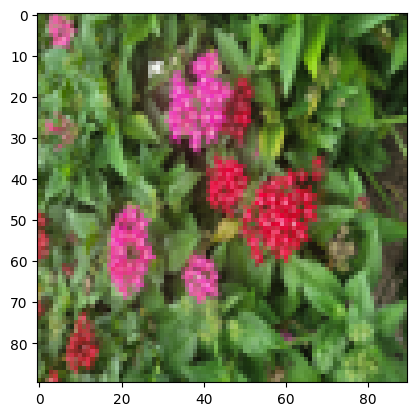

In [ ]:
#Si queremos visualizar las imágenes del conjunto de datos (no las matrices numéricas)
import matplotlib.pyplot as plt
plt.imshow(images[5,:,:,:])

Aumentamos los datos utlizando el ImageDataGenerator de Keras

In [ ]:
#Seleccionamos una imágen de la base de datos
image = images[5,:,:,:]
#Añadir la imagen a un lote
image = tf.expand_dims(image, 0)

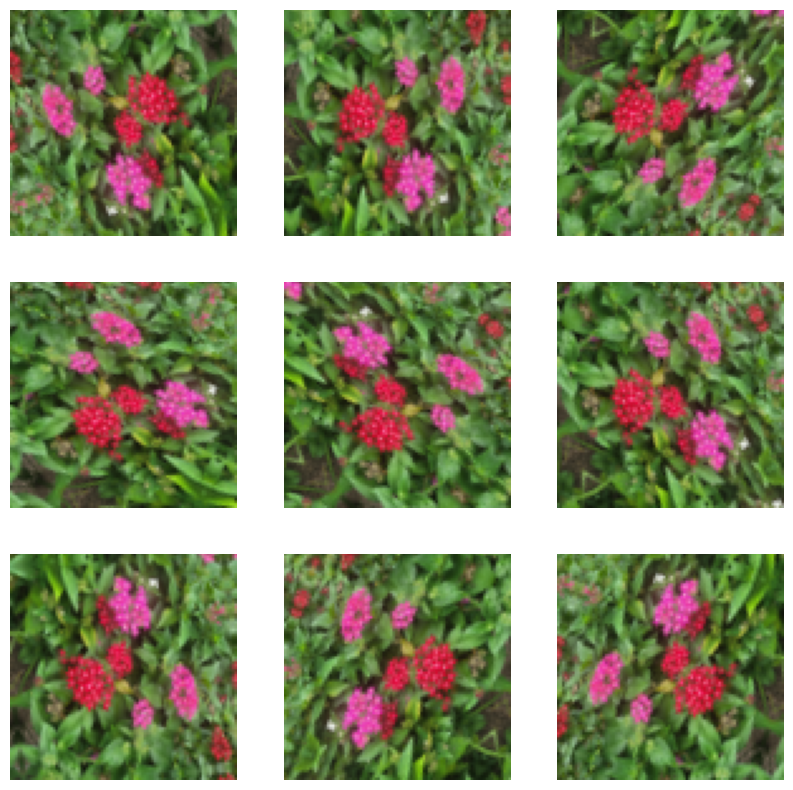

In [ ]:
#Se crean algunas capas de preprocesamiento y se aplican repetitivamente a la misma imagen
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),])

#Visualizamos
plt.figure(figsize=(10, 10))
for i in range(9):
    #Aplicamos data_augmentation
    augmented_image = data_augmentation(image)
    #Mostrar la imagen aumentada
    ax = plt.subplot(3, 3, i + 1)

    #Como la imagen puede no tener las dimensiones correctas, la comprimimos para obtener (90, 90, 3) para imshow (solo la primera dimension)
    plt.imshow(tf.squeeze(augmented_image, axis=0))  # Se agrega axis=0 para comprimir
    plt.axis("off")

In [ ]:
#Seleccionamos una imágen de la base de datos
image = images[5, :, :, :]
#Añadimos la imagen a un lote
image = tf.expand_dims(image, 0)

#Se crean algunas capas de preprocesamiento y se aplican repetitivamente a la misma imagen
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

#Creamos los datos de prueba y de entrenamiento
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

batch_size = 32
num_parallel_calls = tf.data.AUTOTUNE
buffer_size = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Convertir las etiquetas a tensores
  ds = ds.map(lambda img, label: (tf.image.resize(img, img_size), label), num_parallel_calls=num_parallel_calls)

  if shuffle:
    ds = ds.shuffle(1000)

  ds = ds.batch(batch_size)

  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=num_parallel_calls)

  return ds.prefetch(buffer_size=buffer_size)


train_ds = prepare(train_ds, shuffle=True, augment=True)
test_ds = prepare(test_ds)

In [ ]:
#Construimos el modelo de red neuronal

#Definimos que el modelo será secuencial (una copia después de la otra)
model = models.Sequential()

#Agregamos las capas de la red
model.add(layers.Flatten(input_shape=(img_size[0], img_size[1], 3)))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(2, activation = 'softmax'))

In [ ]:
#Compilamos el modelo
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  epochs=epochs
)

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8237 - loss: 0.3987
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8204 - loss: 0.3531
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8207 - loss: 0.3999
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7914 - loss: 0.4340
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8545 - loss: 0.3811


In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7232 - loss: 0.6505
Accuracy 0.7254902124404907
